In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import re
import regex as re
from utils import unit, full_regex

species = pd.read_excel('plant_info.xlsx').set_index('SpeciesName')
print(len(species), '->', len(species[species.Features.notnull()]))
species = species[species.Features.notnull()]
leaf_shapes = pd.read_excel('Words before and after traits_v2.xlsx', sheet_name='Leaf shapes')

2014 -> 1336


# Tabular features

Pipeline: Partire da Leafsize (con aggiunte), predizione delle 2 features e/o dell'area. Estendere pian piano ad features con 

- Associare la forma della foglia a ogni specie
- Ad ogni parola un'immagine modello

- Ho una formina della foglia, rileva la corrispondeza più vicina nell'immagine corrispondente, dando in input magari anche L e W

**IDEA:**
- Prendere le immagini di foglie, le caratteristiche tabulari, e formine.
- Alleno il modello con una soft-label generata dalla formina e dalle dimensioni. Alleno il modello ottimizzato per la soft-label più una loss unsupervised che mi permette di avere una soft-label migliore (?)


### Filogenesi

Alcuni caratteri sono conservati: due specie imparentate sono per forza più simili  (frutto). Questo non vale per altri, ad esempio foglie.

- Ad ogni genere calcolo il size range (min, max), l'a

## Produce

### Extraction

In [43]:
extra_features_df = pd.read_excel("Words before and after traits_v2.xlsx", sheet_name="Words", skiprows=1)
extra_features_df = extra_features_df[:extra_features_df[extra_features_df.Stature.eq('Following words')].index[0]].applymap(lambda s:s.lower().strip() if type(s) == str else s)

extra_features = extra_features_df.to_dict('list')
extra_features = {k.title().replace(' ', ''): [x for x in v if str(x) != 'nan'] for k, v in extra_features.items()}

In [44]:
all_words = extra_features_df.to_numpy().flatten()
# duplicated words
duplicate_words = []
for word in set(all_words):
	if (all_words == word).sum() > 1:
		duplicate_words.append(word)
print(set(duplicate_words).difference({'achene', 'cypsela', 'floret', 'florets', 'stigma-style'}))

{'cypselae', 'achenes', 'cypselas', 'stigma-styles'}


In [45]:
words_to_remove = []
# remove all words starting with petal, flower, fruit, seed with a letter after different from s. Select the entire word up to the first space or punctuation (,;.) excluded
reg_exp = r'(petal|flower|fruit|seed)[a-rt-z]+[^\s;,.\)]'
for i, row in species.Features.items():
	# print(row)
	for word in re.finditer(reg_exp, row):
		words_to_remove.append(word.group())

words_to_remove = list(set(words_to_remove))

In [46]:
unit = '[m|c|d]?m'
# unit = '[m|c|d]m|(?<=\d)m(?!m)'
# 150–400x100–300mm
number = r"(\d+\.?\d*)"
# full_regex = rf"(({number}-)?{number}{unit}?x)?{number}(-{number})?{unit}" ## Supposed to be correct
"""anomaies:
	0.05-0.35-1mx1.5-3-6mm
"""
full_regex = rf"({number}(-{number})?(-{number})?{unit}?x)?({number}(-{number})?(-{number})?{unit}?x)?{number}(-{number})?(-{number})?(-{number})?{unit}"

In [102]:
leaf_shapes[leaf_shapes['Shape words'].apply(lambda w: w in f)]['Leaf shape'].item()

'ovate'

In [177]:
tmp = []
anomalies = set() # species with anomalies

def extract_features(i, feats:list):
	features = {}
	for feat in feats:
		if len(feat) < 1:
			continue
		feat = feat.replace(',', ' ')
		measures = re.finditer(full_regex, feat)
		for measure in measures:
			found = None
			for key, values in extra_features.items():

				feat = feat[:-1] if feat[-1] in ['.', ';'] else feat # remove any of .; at the end of the sentence
				matched_word = list(re.finditer( r'\b('+ '|'.join([w for w in set(values)]) + r')\b', feat.lower()))
				
				if any(matched_word):	
					if key == 'LeafSize':# Extract leaf shape also
						if 'LeafShape' in features and features['LeafShape']:
							continue
						leaf_words_positions = np.array([fword.start() for fword in matched_word])
						leaf_shapes_positions = [next(re.finditer(leaf_shape, feat.lower())).start() if leaf_shape in feat.lower() else np.inf for leaf_shape in leaf_shapes['Shape words'].str.lower()]
						# find the closest leaf shape to the leaf word (the distance is the minimum distance between all the leaf words for each leaf shape)
						leaf_shapes_distances = np.array([np.abs(leaf_words_positions - leaf_shape_position).min() for leaf_shape_position in leaf_shapes_positions])
						if leaf_shapes_distances.min() != np.inf:
							this_leaf_shape = leaf_shapes['Leaf shape'].iloc[leaf_shapes_distances.argmin()]
							features['LeafShape'] = this_leaf_shape	

					if key != 'Stature': # TODO: Caso up to 3m, petiole 2mm???
						matched_word = [w for w in matched_word if w.span()[0] < measure.span()[0]]
						if not any(matched_word):
							continue # if not stature and measure appears before the word, skip
					matched_word = sorted(matched_word, key=lambda word: word.span()[1] - measure.span()[0])[0]

					# Priorities: Stature > ...
					if found and found[0] == 'Stature':
						continue
					if found and found[0] in ['StamenSize', 'AntherSize', 'StigmaSize', 'StyleSize', 'OvarySize', 'PetioleSize', 'PedicelSize'] and key in ['FlowerSize', 'PetalSize']:
						continue # Place in stamen size, anther size, stygma size, style size, ovary size respectively, ignoring flower and petal size
					if found and found[0] =='InflorescenceSize' and key == 'FlowerSize':
						continue # if inflorencence was already found, skip flower (e.g., "flower stem" associated with inflorescence only)
					if found and found[0] == 'SeedSize' and key=='FruitSize' and not any([w in feat.lower() for w in ['achene', 'cypsela']]):
						continue # If a key word for seed size and e.g. "per fruit" are contained in the string: Place the values in seed size only
					if found and found[0] == 'FruitSize' and key!='SeedSize': # the last condition should be redundant
						continue # word for fruit size is used, except cypsela or achene: Ignore other words and place in fruit size

					this_distance = abs(matched_word.span()[1] - measure.span()[0])
					# this_distance = abs(word_match_position - measure_position)
					if found:
						if (any([w in feat.lower() for w in ['achene', 'cypsela']]) and {key, found[0]} == {'FruitSize', 'SeedSize'}) or\
						   (any([w in feat.lower() for w in ['stigma-style']]) and {key, found[0]} == {'StigmaSize', 'StyleSize'}) or\
						   (any([w in feat.lower() for w in ['floret']]) and {key, found[0]} == {'RayFloretsSize', 'DiskFloretSize'}):
							pass
							# print(f'OK>> Multiple features found ({found}, {key}) in "{feat}"')
						else:
							if this_distance >= found[1]:
								continue
							else:
								# print(found, key, matched_word, measure)
								features[found[0]].remove(found[2])
							anomalies.add(i)
					found = (key, this_distance, measure.group())
					
					if key in features:
						features[key].append(measure.group())
					else:
						features[key] = [measure.group()]
	# if 'LeafShape' in features:
	# 	# print(features['LeafShape'], leaf_shapes[leaf_shapes['Shape words'].apply(lambda w: w in features['LeafShape'])]['Leaf shape'].unique())
	# 	features['LeafShape'] = leaf_shapes[leaf_shapes['Shape words'].apply(lambda w: w in features['LeafShape'])]['Leaf shape'].unique()[0]
	return pd.Series(features)

In [178]:
def string_preprocessing(s):
	s = s.replace('\xa0', ' ').replace('×', 'x').replace('–', '-').replace('·', '.') # remove non-breaking space and replace multiplication sign with x
	s = re.sub(r'(?<=xcluding)\s+[\w-]+', ' ', s) # remove each word following "excluding" (Mericarps (excluding style) 2.5-3.0 mm should point to "Mericarps")
	s = re.sub(fr'-?\(-?{number}-?\)-?', '', s) # remove all parentesis surrounding a number (e.g. (-1.5))
	s = s.replace('--', '-').replace('-.', '-').replace('..', '.')
	s = s.replace('(', '').replace(')', '')
	s = re.sub(r'\s(c|ca|o)\.', ' foo ', s) # remove all ' c.'
	s = re.sub(r'(?<=\d)\s+(?=[cmd]?m)', '', s) # remove all spaces before measures (mm, cm, dm, m, these strings only if padded by a space)
	s = re.sub(r'\s*-\s*', '-', s) # remove spaces around hyphens
	s = re.sub(r'(?<=\d)\s*\.(?=\d)', '.', s) # remove spaces before dot if followed and preceded by a number
	s = re.sub(r'(?<=\s)\.(?=\d)', '0.', s) # add a 0 before a dot if it is preceded by a space and a "not number" and followed by a number (e.g. foo .5 --> foo 0.5)
	s = re.sub(r'(?<=[\dm])\s*x\s*(?=\d+)', 'x', s) # remove spaces around x in formulas
	s = re.sub(rf'(;\s*)({full_regex})', r' \2', s) # point to any ';' preceding a measure (full_regex) and remove it, without removing the measure
	# now all measures are supposed to have no spaces between number and unit and spaces around them

	s = re.sub(rf'(?<=\d{unit})(\s*long,?\s*)(?={number}{unit})', r'x', s) # remove any 'long' after a measure ("2 mm long X 3 mm wide" --> "2 mm x 3 mm wide")
	s = re.sub(rf'(?<=\d)([m|c|d]m|m(?!m))(?!x)', r'\1 ', s) # fix situation in which a measure is not followed by a space, in the case, add that space
	s = re.sub(r'(?<![\d\sx\.-])(\d)', r' \1', s) # fix the situation in which a measure (the whole number and measure) is not preceded by a space. In the case, add a space before the measure
	s = re.sub(rf'(?<=\s)-(?=\d)', '', s) # remove '-' at the beginning of a measure (e.g. -1.5 --> 1.5)
	s = re.sub(r'(?<=\d\.\d+)(\.\d?)', '', s) # fix the error in which there is a doubled dot in a number (e.g. 1.5.2), in the case, remove the second dot and the eventual numbers after it
	s = re.sub(r'(?<=[a-ln-z])-(?=\d)', ' ', s) # remove all '-' preceded by a letter (different from m) and followed by a number (e.g. to-250mm --> to 250mm)
	s = re.sub(r'(?<![a-z])(l|I)(?=[\s\.-]|\d)', '1', s) # replace all 'l' or "I" characters which should be '1' (e.g. l.5 --> 1.5). This should be followed by a space, a dot, a hyphen, or a number and not preceded by a letter
	return s

In [179]:
features = species.Features.apply(string_preprocessing).str.split(r'(?<!\sc)[.;]\s|;').reset_index().apply(lambda x: extract_features(x.SpeciesName, x.Features), axis=1)
features = features.applymap(lambda x: '; '.join(x) if not isinstance(x, float) else x)
features.index = species.index
features[features.notna().sum(axis=1) > 0].to_csv('processed_features.csv')

In [180]:
features['LeafShape'].notna().sum()

905

---
### Numerical

In [14]:
processed_features = pd.read_csv('processed_features.csv', index_col=0).join(species.Family)
import pint
# use pint to convert units read a measure, like 1.5mm
ureg = pint.UnitRegistry()


In [15]:
range_to_num = np.vectorize(lambda rg: np.array(
	'nan' if rg=='nan' else re.sub('[a-z]', '', rg).split('-')
												).astype(float).mean())
get_unit = np.vectorize(lambda num: re.findall(rf'{unit}', num)[0] if len(re.findall(rf'{unit}', num)) > 0 else '')
# get_unit = lambda rg: set(sum([re.findall(rf'{unit}', x) for x in np.array(rg).flatten()], [])) # TODO: 38 casi con doppia misura

s = '1.1m-1.4x0.3-0.4mm;1.1-1.4x0.3-0.5mm;'
def processDoubleFeat(s:str):
	if s == 'Absent':
		return ['Absent', 'Absent']
	measures = s.split(';') if not isinstance(s, float) else None
	if not measures or len(re.findall('x[^;]*x', s)) > 0: # some anomalies, very rare with more dimensions (e.g. 6.5x15x5-10mm)
		return [None, None]
	measures = [x.strip().split('x') for x in measures]

	if any([len(x) > 1 for x in measures]):
		# keep only the measures with 2 numbers
		measures = np.array([x for x in measures if len(x) == 2])
	else:
		# keep only the first 2 of 1 and merge together
		if len(measures) < 2: measures = measures[0] + ['nan']
		measures = np.array(measures[:2]).reshape(1, 2)

	units = get_unit(measures) # array of units
	
	for i in range(2):
		if not any(units[:, i]):
			units[:, i] = np.unique(units[:, 1-i])[0]
		if not all(units[:, i]):
			units[:, i] = np.unique(units[:, i][units[:, i]!=''])[0]
	top_unit = np.unique(units.flatten()[units.flatten()!=''])[0]
	measures = range_to_num(measures)

	to_pint = np.vectorize(lambda num, unit: (num * ureg(unit)).to(top_unit).magnitude)
	measures = to_pint(measures, units)
	return [str(m) for m in (measures * ureg(top_unit)).squeeze()]

In [16]:
def processSingleFeat(s:str):
	# convert 100-300mm to mean(100, 300) -> 200 (drop the measure if present: replace any letter with '')
	if s == 'Absent':
		return 'Absent'
	measures = s.split(';') if not isinstance(s, float) else None
	if not measures:
		return None
	measures = np.array(measures)
	units = get_unit(measures) # array of units
	top_unit = np.unique(units.flatten()[units.flatten()!=''])[0]
	
	if not any(units):
		units[units == ''] = top_unit
	measures = range_to_num(measures).mean(axis=0)

	to_pint = np.vectorize(lambda num, unit: (num * ureg(unit)).to(top_unit).magnitude)		
	measures = to_pint(measures, units)
	return str((measures * ureg(top_unit)).squeeze())

In [18]:
col

'LeafShape'

In [19]:
from tqdm import tqdm

data = pd.DataFrame(index=processed_features.index)
for col in tqdm(processed_features.columns):
	if col in ['Family', 'LeafShape']:
		continue
	top_unit = ureg.Unit(processed_features[col].dropna().str.extract(rf'({unit})').value_counts().index[0][0])
	if processed_features[col].str.contains('x', na=False).any():
		# print(f"(double {data[col].str.contains('x', na=False).sum() / data[data[col].notna()& ~data[col].eq('Absent')].shape[0]: .2%})")
		# data[col] = processed_features[col].apply(processDoubleFeat)
		data[f"{col}_l"], data[f"{col}_w"] = zip(*processed_features[col].apply(processDoubleFeat))
		data[f"{col}_l"] = data[f"{col}_l"].apply(lambda x: ureg.Quantity(x).to(top_unit).magnitude if isinstance(x, str) else x)
		data[f"{col}_w"] = data[f"{col}_w"].apply(lambda x: ureg.Quantity(x).to(top_unit).magnitude if isinstance(x, str) else x)
	else:
		data[col] = processed_features[col].apply(processSingleFeat)
		data[col] = data[col].apply(lambda x: ureg.Quantity(x).to(top_unit).magnitude if isinstance(x, str) else x)

data = data.join(species.Family)

100%|██████████| 29/29 [00:09<00:00,  3.17it/s]


In [20]:
data['InflorescenceSize_isabsent'] = processed_features.Family.isin(['Podocarpaceae', 'Cupressaceae', 'Araucariaceae'])
data['CalyxSize_isabsent'] = processed_features.Family.isin(['Poaceae', 'Cyperaceae', 'Juncaceae', 'Restionaceae', 'Podocarpaceae', 'Cupressaceae', 'Araucariaceae'])
data['CorollaSize_isabsent'] = processed_features.Family.isin(['Poaceae', 'Cyperaceae', 'Juncaceae', 'Restionaceae', 'Podocarpaceae', 'Cupressaceae', 'Araucariaceae'])
for c in ['OvarySize', 'StigmaSize', 'StyleSize', 'StamenSize', 'AntherSize']:
	data[c+'_isabsent'] = processed_features.Family.isin(['Podocarpaceae', 'Cupressaceae', 'Araucariaceae'])
for c in ['Lemma', 'Palea', 'Lodicules']:
	data[c+'_isabsent'] = ~processed_features.Family.isin(['Poaceae'])
data['PetalSize_isabsent'] = processed_features.Family.isin(['Poaceae', 'Cyperaceae', 'Podocarpaceae', 'Cupressaceae', 'Araucariaceae'])
data['PappusSize_isabsent'] = ~processed_features.Family.isin(['Asteraceae'])
data['SepalSize_isabsent'] = processed_features.Family.isin(['Poaceae', 'Cyperaceae', 'Juncaceae', 'Restionaceae', 'Podocarpaceae', 'Cupressaceae', 'Araucariaceae'])

In [7]:
for col in data.columns:
	if col.endswith('_l'):
		# regex to check if the string contains 2 'x' but no ';'
		anom_rx = r'(?<!;)(x[^;]*x)(?!;)'
		anomalies = processed_features[col.replace('_l', '')].str.extract(anom_rx).notna()[0]
		try:
			assert (data[col].notna() == (processed_features[col.replace('_l', '')].notna()|anomalies)).all(), f'{col}'
		except:
			print(processed_features[data[col].notna() != (processed_features[col.replace('_l', '')].notna()|anomalies)][col.replace('_l', '')])
	elif col.endswith('_w'):
		anom_rx = r'(?<!;)(x[^;]*x)(?!;)'
		try:
			assert (data[col].notna() == (processed_features[col.replace('_w', '')].str.contains('x|;|A', na=False)|anomalies)).all(), f'{col}'
		except:
			pass
			# print(processed_features[data[col].notna() != (processed_features[col.replace('_w', '')].str.contains('x|;|A', na=False)|anomalies)][col.replace('_w', '')])
	else:
		assert (data[col].notna() == processed_features[col].notna()).all(), f'{col}'

SpeciesName
freycinetia-banksii                              150x30mm; 8x2x10mm
plantago-udicola       2.2-3.5x1.4-2.9mm; 2.1-4.7x1.4-3.2x0.8-1.9mm
Name: FruitSize, dtype: object
SpeciesName
wahlenbergia-cartilaginea      8x5-25x15mm
sebaea-ovata                 6.5x15x5-10mm
Name: LeafSize, dtype: object
SpeciesName
wahlenbergia-matthewsii    10x6-20x8mm
Name: LobesSize, dtype: object
SpeciesName
pachycladon-stellatum    1.1-1.4x0.5-0.7x0.3-0.4mm; 0.2-1.0mm
Name: SeedSize, dtype: object
SpeciesName
freycinetia-banksii    2-4x1mmx2mm
Name: Stature, dtype: object


In [21]:
data.to_csv('processed_features_num.csv')

---

In [22]:
processed_features = pd.read_csv('processed_features_num.csv', index_col=0)
cat_features = pd.read_excel('Words before and after traits_v2.xlsx', sheet_name='Categorical traits').drop(columns=['FlowerSize'])
# TODO: Verificare il significato di "FlowerSize" in questa tabella

In [23]:
processed_features

,AntherSize_l,AntherSize_w,CalyxSize_l,CalyxSize_w,CorollaSize_l,CorollaSize_w,DiskFloretSize_l,DiskFloretSize_w,FlowerSize_l,FlowerSize_w,...,StigmaSize_isabsent,StyleSize_isabsent,StamenSize_isabsent,AntherSize_isabsent,Lemma_isabsent,Palea_isabsent,Lodicules_isabsent,PetalSize_isabsent,PappusSize_isabsent,SepalSize_isabsent
SpeciesName,,,,,,,,,,,,,,,,,,,,,
aciphylla-dieffenbachii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,True,True,True,False,True,False
aciphylla-traversii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,True,True,True,False,True,False
astelia-chathamica,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,True,True,True,False,True,False
austroderia-turbaria,2.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,True,True,True
brachyglottis-huntii,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,25.0,NaN,...,False,False,False,False,True,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dacrycarpus-dacrydioides,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,...,True,True,True,True,True,True,True,True,True,True
prumnopitys-taxifolia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,True,True,True,True,True,True
dacrydium-cupressinum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.5,NaN,...,True,True,True,True,True,True,True,True,True,True


In [23]:
# join with leaf shapes

leaf_shapes = pd.read_excel('Words before and after traits_v2.xlsx', sheet_name='Leaf shapes')
leaf_shapes

def shapeinFeatures(feat:str):
	return leaf_shapes[leaf_shapes['Shape words'].apply(lambda x: x.lower() in feat.lower())]['Leaf shape'].unique()

tmp = species[species.index.isin(processed_features.index)].Features.apply(shapeinFeatures)

In [31]:
print('\n'.join(tmp[tmp.apply(len) == 0].index.tolist()))

astelia-chathamica
festuca-coxii
aciphylla-cartilaginea
rhopalostylis-baueri
cordyline-indivisa
cordyline-pumilio
brachyglottis-sciadophila
olearia-arborescens
pachystegia-minor
raoulia-parkii
pachycladon-fastigiatum
colobanthus-brevisepalus
bolboschoenus-caldwellii
carex-allanii
carex-litorosa
carex-secta
gahnia-rigida
schoenoplectus-tabernaemontani
montigena-novae-zelandiae
gentianella-luteoalba
juncus-usitatus
luzula-celata
utricularia-delicatula
alepis-flavida
peraxilla-colensoi
peraxilla-tetrapetala
tupeia-antarctica
carpobrotus-glaucescens
pterostylis-irsoniana
pterostylis-montana
pittosporum-kirkii
pittosporum-rangitahua
veronica-scrupea
agrostis-petriei
anthosachne-aprica
anthosachne-sacandros
austroderia-fulvida
austroderia-richardii
austroderia-splendens
austroderia-toetoe
chionochloa-antarctica
chionochloa-beddiei
chionochloa-bromoides
chionochloa-nivifera
chionochloa-oreophila
chionochloa-ovata
chionochloa-vireta
connorochloa-tenuis
deschampsia-cespitosa
poa-billardierei
sp

**⚠️ Missing species:**
'callitriche-chathamensis', 'poa-polyphylla', 'senecio-antipodus', 'tecomanthe-speciosa'

In [4]:
processed_features = processed_features.join(cat_features.set_index(cat_features.SpeciesName.str.lower().str.replace(' ', '-')), rsuffix='cat')

In [5]:
processed_features[processed_features.Familycat.str.strip() != processed_features.Family.str.strip()][['Family', 'Familycat']].drop_duplicates(subset=['Family', 'Familycat'])

,Family,Familycat
SpeciesName,,
callitriche-chathamensis,Plantaginaceae,NaN
melicytus-chathamicus,Violaceae,Violaceace
pennantia-baylisiana,Pennantiaceae,Pennatiaceae
poa-polyphylla,Poaceae,NaN
senecio-antipodus,Asteraceae,NaN
tecomanthe-speciosa,Bignoniaceae,NaN
thismia-rodwayi,Thismiaceae,Burmanniaceae
convolvulus-waitaha,Convolvulaceae,Convolvulacae
lobelia-anceps,Campanulaceae,Lobeliaceae


In [6]:
processed_features = processed_features.drop(columns=['Familycat'])

In [72]:
#cat_features.columns.difference(['Genus', 'SpeciesName'])
pd.get_dummies(processed_features, columns=cat_features.columns.difference(['Genus', 'SpeciesName']), dummy_na=False).to_csv('processed_features_num_cat.csv')

## Analysis

💡 **TODO:** dalle foglie calcolare l'area, forma descritta nel testo (dati categorici)

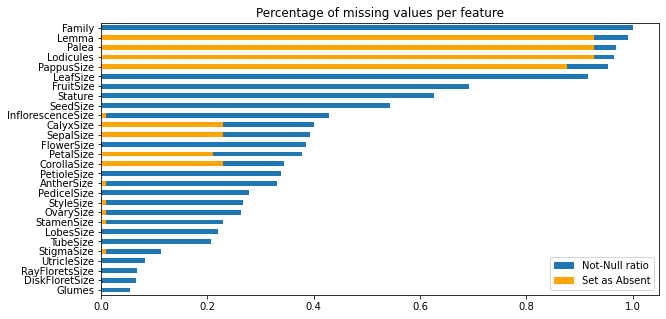

In [126]:
tmp = (processed_features.notna().sum(axis=0)/len(processed_features)).sort_values()
tmp.plot.barh(figsize=(10, 5), title='Percentage of missing values per feature', label='Not-Null ratio')
(processed_features.eq('Absent').sum(axis=0)/len(processed_features)).loc[tmp.index].plot.barh(figsize=(10, 5), title='Percentage of missing values per feature', color='orange', label='Set as Absent')
plt.legend()
plt.show()

<Axes: title={'center': 'Percentage of missing values per species'}, ylabel='Frequency'>

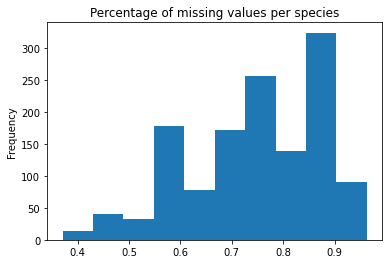

In [65]:
(processed_features.isna().sum(axis=1)/processed_features.shape[1]).sort_values(ascending=False).plot.hist(title='Percentage of missing values per species') #.plot.barh(figsize=(10, 5), title='Percentage of missing values per species')

In [28]:
sp = 'myosotis-antarctica'
ft = species.iloc[species.index.get_loc(sp):species.index.get_loc(sp)+1].Features
print(ft.apply(string_preprocessing).str.split(r'(?<!\sc)[.;]\s|;')[0])
ft.apply(string_preprocessing).str.split(r'(?<!\sc)[.;]\s|;').reset_index().apply(lambda x: extract_features(x.SpeciesName, x.Features), axis=1)

['Perennial rosette-leaved herb', 'Rosette leaves 10-20x4-5mm , lamina obovate, obtuse, petiole short, broad', 'hairs on upper surface crowded, long, soft and silky, those of under-surface sparse, glabrate', 'Lateral branches numerous, decumbent, up to 70mm  long, occasionally branched, internodes usually < leaves', 'Stem-leaves similar to rosette-leaves near base, becoming sessile above, bracts foo 5x2mm ', 'Cymes usually simple, few-, bracteate except at extreme tip, internodes, except the lowest, very short', 'pedicels foo 1mm  long', 'Calyx foo 3mm  long, lobes > 1/ 2 length, broad and subacute', 'hairs mostly very long and soft, a few short and closely appressed', 'Corolla blue occasionally white, 2-3mm  diam, tube cylindric, 2mm  long, lobes 1.0-1.5mm  long, ± parallel-sided, narrowing above to obtuse tip', 'filaments very short, anthers < 1mm , wholly included, tips not reaching scales', 'style < calyx, stigma clavate', 'Nutlet 1.1-1.4x0.7-1.0mm , ovate, black.']
('CorollaSize',

,LeafSize,PedicelSize,CalyxSize,CorollaSize,TubeSize,LobesSize,StamenSize,AntherSize,FruitSize
0,"[10-20x4-5mm, 5x2mm]",[1mm],[3mm],[2-3mm],[2mm],[1.0-1.5mm],[],[1mm],[1.1-1.4x0.7-1.0mm]


### Warm-up: Leafsize imputation

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

np.random.seed(42)

data_leaf = processed_features[~processed_features.LeafSize_l.eq('Absent')].drop(columns=['Family', 'Genus', 'SpeciesName']).replace('nan', np.nan).replace('Absent', np.nan)
# convert to numeric all features if possible
data_leaf = data_leaf.apply(pd.to_numeric, errors='ignore')
expected_cols = len(data_leaf.columns) + sum([data_leaf[col].nunique() - 1 for col in data_leaf.columns if data_leaf[col].dtype == 'object'])
cat_cols = data_leaf.dtypes[data_leaf.dtypes == 'object'].index
	# apply one-hot encoding to all categorical features
data_leaf = pd.get_dummies(data_leaf, columns=cat_cols, dummy_na=False)
assert len(data_leaf.columns) == expected_cols, f'Expected {expected_cols} columns, got {len(data_leaf.columns)}'

data_leaf = data_leaf.fillna(-1).astype(float)

data_leaf = data_leaf[data_leaf.LeafSize_l != -1]
data_leaf = data_leaf[data_leaf.LeafSize_l < data_leaf.LeafSize_l.quantile(0.8)]

X = data_leaf.drop(columns=['LeafSize_l', 'LeafSize_w'])
# y = data_leaf[['LeafSiz§e_l', 'LeafSize_w']]
y = data_leaf['LeafSize_l']
train_idx, test_idx = train_test_split(data_leaf.index, test_size=0.2, random_state=42)
X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

models = {
	'RandomForestRegressor': RandomForestRegressor(),
	# 'GradientBoostingRegressor': GradientBoostingRegressor(),
}

for name, model in models.items():
	model.fit(X_train, y_train)
	y_pred = model.predict(X_test)
	print(f'\n{name} (LeafSize_l, max={data_leaf.LeafSize_l.max()})')
	print(f'rMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}')
	print(f'r2: {r2_score(y_test, y_pred):.4f}')


RandomForestRegressor (LeafSize_l, max=162.5)
rMSE: 33.2652
r2: 0.2241


/home/simone/miniconda3/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


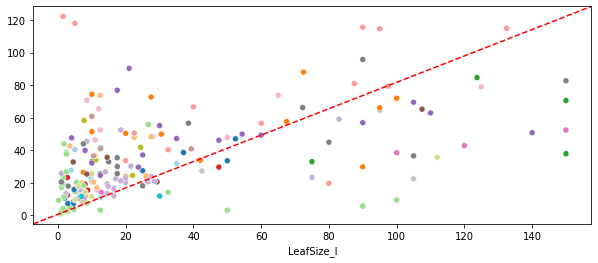

In [70]:
import seaborn as sns
tmp = processed_features[(processed_features.LeafSize_l != 'Absent')&(processed_features.LeafSize_l.notna())]
tmp = tmp[tmp.LeafSize_l<tmp.LeafSize_l.quantile(0.9)]
fam = tmp.Family[test_idx]

fig, ax = plt.subplots(figsize=(10, 4))
# color by tmp.Family
sns.scatterplot(y_test, y_pred, hue=fam, palette='tab20', legend=None)
plt.plot([0, y_test.max()], [0, y_test.max()], transform=ax.transAxes, ls='--', c='red')

(array([102.,  35.,  11.,   9.,   6.,   9.,  10.,   4.,   3.,   5.]),
 array([  0.2 ,  15.18,  30.16,  45.14,  60.12,  75.1 ,  90.08, 105.06,
        120.04, 135.02, 150.  ]),
 <BarContainer object of 10 artists>)

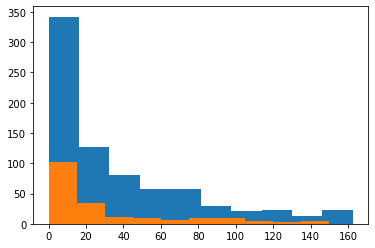

In [205]:
plt.hist(y_train)
plt.hist(y_test)

### IDEA

- Dataset con valori mancanti
- Imputing missing values (dataset per mainland + dataset per isola, ora solo mainland?)
- Confronto distribuzioni isola con mainland

altrimenti
- Metric uncoupling

In [6]:
processed_features.isna().sum() / processed_features.shape[0]

AntherSize           0.800894
CalyxSize            0.850546
CorollaSize          0.914598
FlowerSize           0.722443
FruitSize            0.710526
Glumes               0.961271
InflorescenceSize    0.662860
LeafSize             0.524330
Lemma                0.956802
Lodicules            0.975174
OvarySize            0.856008
Palea                0.972195
PedicelSize          0.790467
PetalSize            0.893247
PetioleSize          0.751241
SeedSize             0.720953
StamenSize           0.960775
Stature              0.763158
StigmaSize           0.944389
StyleSize            0.848064
TubeSize             0.900199
dtype: float64

<Axes: >

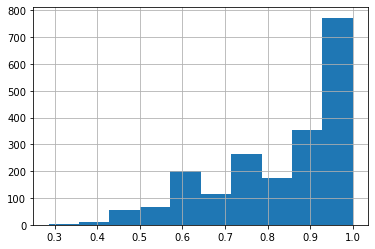

In [10]:
(processed_features.isna().sum(axis=1) / processed_features.shape[1]).sort_values(ascending=False).hist()

# Graph features

In [58]:
for rec in SeqIO.parse(filename, "nexus"):
	print(rec.id)
	print(repr(rec.seq))
	print(len(rec))

In [62]:
from Bio import Phylo
# load graph in format nexus.nex:
# ((((((((((((((((((((((Centipeda_cunninghamii:2.334467,Centipeda_minima:2.334467):0.095721,Centipeda_aotearoana:2.430188):0.012004,Centipeda_elatinoides:2.442192):18.460732,(((((Helichrysum_dimorphum:1.556045,Helichrysum_depressum:1.556045,Helichrysum_coralloides:1.556045,(Helichrysum_filicaule:0.528987,Helichrysum_lanceolatum:0.528987):1.027059):0.528609,(Pseudognaphalium_luteoalbum:0.274923,Pseudognaphalium_ephemerum:0.274923):1.809731):2.322955,(((Raoulia_subulata:1.375638,Raoulia_subsericea:1.375638,Raoulia_petriensis:1.375638,Raoulia_parkii:1.375638,Raoulia_haastii:1.375638,Raoulia_cinerea:1.375638,Raoulia_bryoides:1.375638,Raoulia_beauverdii:1.375638,Raoulia_apicinigra:1.375638,Raoulia_albosericea:1.375638,(((((Raoulia_buchananii:0.002972,Raoulia_goyenii:0.002972):0.348722,Raoulia_eximia:0.351694):0.101627,Raoulia_rubra:0.453321):0.21017,Raoulia_youngii:0.663491):0.431453,(((Raoulia_glabra:0.373744,Raoulia_australis:0.373744):0.111268,(Raoulia_monroi:0.246199,Raoulia_hookeri:0.246199):0.238813):0.489619,Raoulia_mammillaris:0.974631):0.120313):0.280695,(Raoulia_grandiflora:1.300999,Raoulia_hectorii:1.300999):0.07464):0.141717,(Rachelia_glaria:1.370926,Ewartiothamnus_sinclairii:1.370926):0.14643):0.008985,((...

# load graph in format nexus.nex:
filename = "allNZspecies.nexus.nex"
tree = Phylo.read(filename, "newick")

**Distanza come lunghezza dei rami**

<Figure size 720x1800 with 0 Axes>

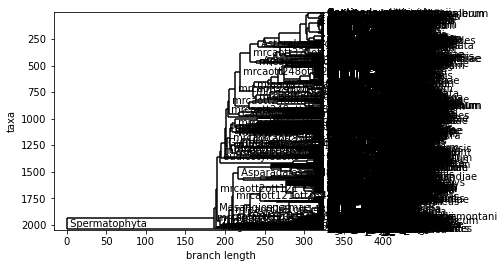

In [70]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 25))
Phylo.draw(tree, do_show=False)

# Images

_**NOTE:** I don’t know how to help with that package (sorry!) but just a related point:
If you’re planning to use iNat data for a publication of some sort, the preferred route of access is through GBIF which will give you a citeable doi for the dataset._

_Sometimes this isn’t an option if the dataset that you want contains records that aren’t on GBIF (like casual observations, which it looks like you may be wanting), but thought it worth a mention._

In [2]:
from pathlib import Path
from pyinaturalist import get_taxa, pprint, Observation
import pyinaturalist as pi
get_id = lambda spec: next(iter(get_taxa(q=spec)['results']), None)

In [18]:
ob_id = 46054484
Observation.from_id(ob_id).photos[0].ext

'jpeg'

In [274]:
# spec = species.index[29]
spec = 'coprosma-repens'

In [326]:
nz_id = pi.get_places_autocomplete(q='new zealand')['results'][0]['id']

In [328]:
res = pi.get_observations(photos='true', quality_grade='research', order='desc', reviewed='true', taxon_id=76435, page=1, per_page=500, sort='preferred', place_id=nz_id)
pprint(res['results'])

 ID          Taxon ID   Taxon                      Observed on    User                   Location                 
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  192487194   76435      Species: Coprosma repens   Nov 21, 2023   daffodillas            Te Ika-a-Māui/North      
                         (Taupata)                                                        Island, Wellington,      
                                                                                          Wellington, NZ           
  192302962   76435      Species: Coprosma repens   Nov 27, 2023   natigrowth             Kaiti, Gisborne 4010,    
                         (Taupata)                                                        New Zealand              
  192113508   76435      Species: Coprosma repens   Nov 24, 2023   tom_beard              Te Ika-a-Māui/North      
                         (Taupata)                                                        Island, Wellington,      
                                                                                          Wellington, NZ           
  191881805   76435      Species: Coprosma repens   Nov 24, 2023   jfripp                 Stanmore Bay,            
                         (Taupata)                                                        Whangaparāoa, New        
                                                                                          Zealand                  
  191875966   76435      Species: Coprosma repens   Nov 24, 2023   kim16974               Te Wharau School,        
                         (Taupata)                                                        Gisborne, Gisborne, NZ   
  191872372   76435      Species: Coprosma repens   Nov 24, 2023   ktbday                 Khandallah, Wellington   
                         (Taupata)                                                        6035, New Zealand        
  191861888   76435      Species: Coprosma repens   Nov 24, 2023   svendhansen            Onslow Alms - Onslow     
                         (Taupata)                                                        Road (opposite),         
                                                                                          Khandallah, Wellington   
                                                                                          6035, New Zealand        
  191798690   76435      Species: Coprosma repens   Nov 23, 2023   juliascarf             Matiu/Somes Island,      
                         (Taupata)                                                        Lower Hutt, Wellington,  
                                                                                          NZ                       
  191338295   76435      Species: Coprosma repens   Nov 18, 2023   alice804               Mākara Beach,            
                         (Taupata)                                                        Wellington 6972, New     
                                                                                          Zealand                  
  191325789   76435      Species: Coprosma repens   Nov 18, 2023   millie5555             North Island, Ngatea,    
                         (Taupata)                                                        Waikato, NZ              
  191305528   76435      Species: Coprosma repens   Nov 13, 2023   melb7                  Te Ika-a-Māui/North      
                         (Taupata)                                                        Island, Levin,           
                                                                                          Manawatū-Whanganui, NZ   
  190963496   76435      Species: Coprosma repens   Nov 05, 2023   cbeem                  Punakaiki, New Zealand   
                         (Taupata)                                                                                 
  190326001   76435      Species: Coprosma repens   Nov 0

In [276]:
res_imgs = pi.get_observation_species_counts(taxon_id=get_id(spec)['id'])
taxa = pi.TaxonCount.from_json_list(res_imgs)
pprint(taxa)

 ID      Rank      Scientific name      Common name   Count  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  76435   species   🌱 Coprosma repens   Taupata       5064  

In [277]:
res_imgs


{
    'total_results': 1,
    'page': 1,
    'per_page': 500,
    'results': [
        {
            'count': 5064,
            'taxon': {
                'id': 76435,
                'rank': 'species',
                'rank_level': 10,
                'iconic_taxon_id': 47126,
                'ancestor_ids': [
                    48460,
                    47126,
                    211194,
                    47125,
                    47124,
                    47363,
                    47693,
                    788064,
                    636436,
                    1442376,
                    70254,
                    76435
                ],
                'is_active': True,
                'name': 'Coprosma repens',
                'parent_id': 70254,
                'ancestry': '48460/47126/211194/47125/47124/47363/47693/788064/636436/1442376/70254',
                'extinct': False,
                'default_photo': {
                    'id': 1261630,
                   

---

In [242]:
families_id = [get_id(f) for f in species.Family.unique()]
families_id = [f['id'] for f in families_id if f]
Path('families_id.txt').write_text('\n'.join([str(f) for f in families_id]))

In [272]:
species_id_file = Path('species_id.txt')
# remove file if exists
if species_id_file.exists():
	species_id_file.unlink()
with species_id_file.open('a') as wfile:
	for f in tqdm(species.index):
		species_id = get_id(f)
		if species_id:
			wfile.write(f"{species_id['id']}\n")

 30%|██▉       | 598/2014 [08:49<20:54,  1.13it/s]


KeyboardInterrupt: 

670

In [248]:
import json

with open('inat_api/request.json') as f:
	req = json.load(f)

In [254]:
req['results'][0].keys()

dict_keys(['quality_grade', 'time_observed_at', 'taxon_geoprivacy', 'annotations', 'uuid', 'observed_on_details', 'id', 'cached_votes_total', 'identifications_most_agree', 'created_at_details', 'species_guess', 'identifications_most_disagree', 'tags', 'positional_accuracy', 'comments_count', 'site_id', 'created_time_zone', 'license_code', 'observed_time_zone', 'quality_metrics', 'public_positional_accuracy', 'reviewed_by', 'oauth_application_id', 'flags', 'created_at', 'description', 'time_zone_offset', 'project_ids_with_curator_id', 'observed_on', 'observed_on_string', 'updated_at', 'sounds', 'place_ids', 'captive', 'taxon', 'ident_taxon_ids', 'outlinks', 'faves_count', 'ofvs', 'num_identification_agreements', 'preferences', 'comments', 'map_scale', 'uri', 'project_ids', 'community_taxon_id', 'geojson', 'owners_identification_from_vision', 'identifications_count', 'obscured', 'num_identification_disagreements', 'geoprivacy', 'location', 'votes', 'spam', 'user', 'mappable', 'identifica

In [261]:
req['results'][0]['taxon']['default_photo']#.keys()


{
    'id': 4025459,
    'license_code': 'cc-by-nc-nd',
    'attribution': '(c) peaceful-jp-scenery, some rights reserved (CC BY-NC-ND)',
    'url': 'https://inaturalist-open-data.s3.amazonaws.com/photos/4025459/square.jpg',
    'original_dimensions': {'height': 1365, 'width': 2048},
    'flags': [],
    'square_url': 'https://inaturalist-open-data.s3.amazonaws.com/photos/4025459/square.jpg',
    'medium_url': 'https://inaturalist-open-data.s3.amazonaws.com/photos/4025459/medium.jpg'
}

In [239]:
next(iter(get_taxa(q='Rubiaceae')['results']))['id']

47693

 ID      Rank      Scientific name      Common name   Count  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  76435   species   🌱 Coprosma repens   Taupata       5064  

In [230]:
taxa[0].id

76435

In [223]:
tmp = species.assign(inat_ids=ids)[['Features', 'inat_ids']]
tmp[tmp.inat_ids.isna()]

NameError: name 'ids' is not defined

In [74]:

# ids = []
# for spec in species.index:
# 	try:
# 		ids.append(get_id(spec))
# 	except:
# 		print(spec)
# # species_ids = [get_id(species) for spec in species.index]

In [72]:
# taxa = pi.TaxonCount.from_json_list(res_imgs['results'])
taxa = pi.TaxonCount.from_json_list(res_imgs)
pprint(taxa)

AttributeError: 'str' object has no attribute 'items'

In [20]:
res['results'][0]['id']

48363

{'total_results': 5,
 'page': 1,
 'per_page': 30,
 'results': [{'id': 48363,
   'rank': 'species',
   'rank_level': 10,
   'iconic_taxon_id': 47126,
   'ancestor_ids': [48460,
    47126,
    211194,
    47125,
    47124,
    48151,
    48377,
    604091,
    48376,
    48363],
   'is_active': True,
   'name': 'Tecoma stans',
   'parent_id': 48376,
   'ancestry': '48460/47126/211194/47125/47124/48151/48377/604091/48376',
   'extinct': False,
   'default_photo': {'id': 59333691,
    'license_code': 'cc-by-nc-sa',
    'attribution': '(c) sergioniebla, some rights reserved (CC BY-NC-SA), uploaded by sergioniebla',
    'url': 'https://inaturalist-open-data.s3.amazonaws.com/photos/59333691/square.jpeg',
    'original_dimensions': {'height': 1365, 'width': 2048},
    'flags': [],
    'square_url': 'https://inaturalist-open-data.s3.amazonaws.com/photos/59333691/square.jpeg',
    'medium_url': 'https://inaturalist-open-data.s3.amazonaws.com/photos/59333691/medium.jpeg'},
   'taxon_changes_count

In [34]:
res = get_taxa(q="Tecoma stans")
# species.index[29]
Observation.from_id(res)

# get the images of the species


ObservationNotFound: 